# Analysis
In this notebook we will implement some dataset analysis techniques to integrate into Suggester.

In [38]:
import modules
import importlib
import torch
import random
import numpy as np
import modules.models.Linear as Linear
from modules.ActiveLearning import Samplings
from tqdm import tqdm
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from modules import ActiveLearning
from modules import Suggester
from collections import defaultdict


importlib.reload(modules)
importlib.reload(modules.models.Linear)
importlib.reload(modules.ActiveLearning)
importlib.reload(modules.Suggester)


random_seed = 42
torch.cuda.is_available()

True

In [13]:
class TrainConfusion:
    def __init__(self, top_n=10):
        self.top_n = top_n

    def get_most_frequently_confused_classes(self, model, X_train, y_train):
        y_pred = model.predict(X_train)
        conf_dict = {}
        for real, pred in zip(y_train, y_pred):
            if (real != pred):
                mask = (real,pred)
                conf_dict[mask] = conf_dict.get(mask, 0) + 1
        lst = list(conf_dict.items())
        lst = sorted(lst, key=lambda x: -1 * (conf_dict.get((x[0][1],x[0][0]),0) + x[1]))
        tmp = {}
        successfully_added = 0
        for key, val in lst:
            if successfully_added >= self.top_n:
                break
            if (tmp.get((key[1],key[0]),-1) == -1):
                tmp[key] = (val, conf_dict.get((key[1], key[0]),0))
                successfully_added += 1
        return tmp
    
    def pretty_print(self, model, X_train, y_train):
        tmp = self.get_most_frequently_confused_classes(model, X_train, y_train)
        for key, value in tmp.items():
            print(f"{key[0]} was mistaken for {key[1]} {value[0]} times and {key[1]} for {key[0]} {value[1]} times")
        

In [14]:
class FindZeroSamples:
    def __init__(self):
        self.epsilon = 1e-7
    
    def get_zero_samples_count(self, X):
        print(np.argwhere(np.all(abs(X) < self.epsilon, axis=1)))
        return np.count_nonzero(np.all(abs(X) < self.epsilon, axis=1))

In [2]:
def import_dataset():
    le = LabelEncoder()
    vectorized_output_path = "selfpost/vectorized.npy"
    vectorized_labels_output_path = "selfpost/vectorized_labels.npy"
    with open(vectorized_output_path, "rb") as vect_X, open(vectorized_labels_output_path, "rb") as vect_y:
        X = np.load(vect_X, allow_pickle=True)
        y = np.load(vect_y, allow_pickle=True)
    le.fit(y)
    y = le.transform(y)
    return X, y, le.get_params() 

X, y, y_dict = import_dataset()

In [20]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
torch.use_deterministic_algorithms(False)
random.seed(random_seed)
sug = Suggester.Suggester(X,y, test_fraction=0.99)
model = Linear.LinearModelTorch(Linear.LogReg(), 100)
model.train(sug.X_train, sug.y_train)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50009.59it/s]


In [18]:
tconf = TrainConfusion(20)
tconf.pretty_print(model, sug.X_train, sug.y_train)

In [80]:
# Dispute measure: how much n_nearest nearest points' known class counts are unbalanced
# Не уверен, как это впихнуть в саджестр, потому что не совпадает интерфейс с остальными
# методами активлернинга. Возможно, я передаю интерфейс get_samples_for_labeling и буду 
# передавать туда сам suggester
class LabelDisputablePoints:
    def __init__(self, n_top=1000, n_nearest=100):
        self.n_top = n_top
        self.n_nearest = n_nearest
        
# Придумать более адекватную реализацию)
    def get_samples_for_labeling(self, sug, X_test, y_test):
        print(X_test.shape, y_test.shape)
        dist, ind = sug.index.search(sug.X_test, self.n_nearest)
        entropies = np.zeros(sug.X.shape[0], np.float32)
        for i, idx in tqdm(enumerate(ind)):
            mask = np.zeros(sug.X.shape[0], np.bool)
            mask[idx] = True
            mask = mask * sug.is_train_mask
            neigh = np.bincount(sug.y[mask])
            entropies[i] = entropy(neigh, axis=0)
        indices_to_return = np.argsort(entropies)[::-1]
        return indices_to_return[:self.n_top]

In [55]:
from faiss import IndexFlatL2
from modAL.models.base import BaseEstimator
from modAL.utils.data import modALinput
from functools import partial
from modAL.utils.selection import multi_argmax, shuffled_argmax

def _nearest_neighbours_to_entropy(nearest_neighbours: np.ndarray, min_bins: int):
    bin_count = np.apply_along_axis(partial(np.bincount, minlength=min_bins), 1, nearest_neighbours)
    return entropy(bin_count, axis=1)


def disputable_points(classifier: BaseEstimator, X: modALinput,
                               index: IndexFlatL2, n_nearest: int = 100,
                               n_instances: int = 1, random_tie_break: bool = False,
                               **uncertainty_measure_kwargs):
    dist, ind = index.search(X, n_nearest)
    entropies = _nearest_neighbours_to_entropy(classifier.y_training[ind], np.unique(classifier.y_training).shape[0])
    indices_to_return = np.argsort(entropies)[::-1]
    return indices_to_return[:n_instances]

In [13]:
num_of_elements = 100000
subsample = np.random.choice(X.shape[0], num_of_elements, replace=False)
sug = Suggester.Suggester(X[subsample],y[subsample], test_fraction=0.8, build_index=True)

In [ ]:
ldp = LabelDisputablePoints()
ldp.get_samples_for_labeling(sug, sug.X_test, sug.y_test)

In [23]:
arr = np.array([[1, 1, 1], [1, 2, 3], [1, 2, 2]])
_nearest_neighbours_to_entropy(arr, min_bins=4)

array([0.        , 1.09861229, 0.63651417])

In [52]:
import faiss
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from modules.models import Linear
importlib.reload(Linear)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.01, random_state=random_seed)
index = faiss.IndexFlatL2(X_test.shape[1])
index.add(X_train.astype(np.float32))

learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=disputable_points,
    X_training=X_train, y_training=y_train
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.09it/s]


In [53]:
query_idx, query_inst = learner.query(X_test.astype(np.float32), index=index, n_instances=100)

In [54]:
print(query_idx)

[ 57438  47534  17361  56281  55553  50680  16802  52674  50242  70260
  53060  71813  60726  40455  70972  56816  50172  83366  67631  30613
  98789  97989  33731  36447  55315  16865 100338   4367   4992  17184
  63143  16705  64433  29503  37309  42989  68123  57645  16925  15182
  88186  86248  96934  48148  70632  89089  42561  94993  11871  62771
  90671  54461  71559  23168  38862  45270  86572  62658  47845  80249
  31005   5433  12292  27428  42143   6954   7029  42073  44592  16587
  60016  92934  11210  71787  21243  20364  28385  18567   1148  89075
  56296  17103    848  43754  61463   9523  30271  55540  57215  14670
  59491  68820  56912   4014  30474  96031  23807  10289  18179  56291]


In [50]:
print(query_idx)

[ 31005  17184  27428  33731  16925  60726   6954  96934  17361  16587
  86572  54461  98789  56816  50680  67631  70260  62658   7029  60016
  53060  43754  70972  30613  40455  97989  50242  62771  36447  90671
  38862  11210  50172  47534  12292  83366  57438  28385  47845  16865
  71813  17103  52674  63143  16802  48148  55553  15182  68123  70632
   1148  56281  18567  55315  37309  42561  92934  56296 100338  42073
  64433  20364  42143   5433   4992  11871  80249  89089  23168  89075
  21243  71559  44592    848  42989  23807  86248  45270  94993  57645
  88186  71787   4014  55540  30474  29503  16705  30271   4367  61463
  96031  57215  56912  59491  14670  10289   9523  68820  18179  39459]


In [ ]:
class PseudoLabeling(ActiveLearningBase):
    def __init__(self, n_top=1000):
        super().__init__(n_top)
        self.n_top = n_top

    def get_samples_for_labeling(self, model, X_test, y_test):
        y_proba = model.predict_proba(X_test)
        max_ind = np.argmax(y_proba, axis=1)
        y_proba = np.max(y_proba, axis=1)
        ind = np.lexsort((max_ind, y_proba))[::-1]
        ind_to_return = ind[:min(self.n_top, y_proba.shape[0])]
        return "labeling", ind_to_return, max_ind[ind_to_return]

In [63]:
def pseudolabeling(classifier: BaseEstimator, X: modALinput,
                               n_instances: int = 1, random_tie_break: bool = False,
                               **pseudolabeling_kwargs):
        y_proba = classifier.predict_proba(X)
        entropies = entropy(y_proba, axis=1)
        if not random_tie_break:
            return multi_argmax(entropies, n_instances=n_instances)

        return shuffled_argmax(entropies, n_instances=n_instances)

In [68]:
from modules.ActiveLearning import Heuristics
learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=Heuristics.pseudolabeling,
    X_training=X_train, y_training=y_train
)
        


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.86it/s]


In [69]:
query_idx, query_inst = learner.query(X_test.astype(np.float32), index=index, n_instances=100)
print(query_idx)

[ 97153  37280  32696  72395  52367  87998  28018  50899  20218  51106
  37962  20245  64953  84674  77207  51165  49718  40779  81104  28722
   3784  54333  98781  42057   7698   4815  12169  52281  20343 101145
  85234  11335  99270  29636  34824  14096  45884  81811  61271  62900
  29762   2270  38713  12525  57284  22845  10327  41140   1194  35384
  42388  47340  32524  87336  93778  14033  54854  68060  41224  10133
  79071  71149  74153  44389  47224  53922  25879  52013  30363  44246
  24659  30393  94253  85820  49124  51261  45219  57632  29903  42954
  67739  99845  75729  64090  37802  28820  67671  49308  86421  99017
  80174  29243  67466  74939  64502  73943  17153  91719  82439  95477]


In [10]:
learner.teach(X_test[query_idx].astype(np.float32), learner.predict(X_test[query_idx].astype(np.float32)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.48it/s]


In [ ]:
def classifier_random_sampling(classifier: BaseEstimator, X: modALinput,
                               n_instances: int = 1, random_tie_break: bool = False,
                               **uncertainty_measure_kwargs):
    ind = np.random.choice(X_test.shape[0], self.n_top, replace=False)

In [56]:
from faiss import IndexFlatL2
from modAL.models.base import BaseEstimator
from modAL.utils.data import modALinput
from functools import partial
from modAL.utils.selection import multi_argmax, shuffled_argmax

def _nearest_neighbours_to_entropy(nearest_neighbours: np.ndarray, min_bins: int):
    bin_count = np.apply_along_axis(partial(np.bincount, minlength=min_bins), 1, nearest_neighbours)
    return entropy(bin_count, axis=1)


def disputable_points(classifier: BaseEstimator, X: modALinput,
                               index: IndexFlatL2, n_nearest: int = 100,
                               n_instances: int = 1, random_tie_break: bool = False,
                               **uncertainty_measure_kwargs):
    dist, ind = index.search(X, n_nearest)
    entropies = _nearest_neighbours_to_entropy(classifier.y_training[ind], np.unique(classifier.y_training).shape[0])
    indices_to_return = np.argsort(entropies)[::-1]
    print(entropies[indices_to_return[:n_instances]])
    return indices_to_return[:n_instances]

In [ ]:
learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=disputable_points,
    X_training=X_train, y_training=y_train
)
query_idx, query_inst = learner.query(X_test.astype(np.float32), index=index, n_instances=100)
print(query_idx)        


In [58]:
def _nearest_neighbours_to_entropy(nearest_neighbours: np.ndarray, min_bins: int):
    bin_count = np.apply_along_axis(partial(np.bincount, minlength=min_bins), 1, nearest_neighbours)
    return entropy(bin_count, axis=1)


def disputable_points(classifier: BaseEstimator, X: modALinput,
                               index: IndexFlatL2, n_nearest: int = 100,
                               n_instances: int = 1, random_tie_break: bool = False,
                               **disputable_points_kwargs):
    dist, ind = index.search(X, n_nearest)
    entropies = _nearest_neighbours_to_entropy(classifier.y_training[ind], np.unique(classifier.y_training).shape[0])
    if not random_tie_break:
        print(entropies[multi_argmax(entropies, n_instances=n_instances)])
        return multi_argmax(entropies, n_instances=n_instances)

    return shuffled_argmax(entropies, n_instances=n_instances)

In [44]:
import faiss


def import_dataset():
    le = LabelEncoder()
    vectorized_output_path = "selfpost/vectorized.npy"
    vectorized_labels_output_path = "selfpost/vectorized_labels.npy"
    with open(vectorized_output_path, "rb") as vect_X, open(vectorized_labels_output_path, "rb") as vect_y:
        X = np.load(vect_X, allow_pickle=True)
        y = np.load(vect_y, allow_pickle=True)
    le.fit(y)
    y = le.transform(y)
    return X, y, le.get_params() 

X, y, y_dict = import_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.01, random_state=random_seed)
index = faiss.IndexFlatL2(X_test.shape[1])
index.add(X_train.astype(np.float32))

In [11]:
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from modules.models import Linear
from modules.ActiveLearning.Heuristics import disputable_points
importlib.reload(Linear)

learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=disputable_points,
    X_training=X_train, y_training=y_train
)
query_idx, query_inst = learner.query(X_test.astype(np.float32), index=index, n_instances=100)
learner.teach(X_test[query_idx], y_test[query_idx]) 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


In [23]:
import pandas as pd
from modules.models import ModelWrap
from modAL.models import ActiveLearner
from typing import Union
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_metrics(model: Union[ModelWrap, ActiveLearner], X_test: np.ndarray, y_test: np.ndarray) -> pd.DataFrame:
    y_pred = model.predict(X_test)
    metrics = pd.DataFrame({"accuracy": [accuracy_score(y_test, y_pred)],
               "f1_score": [f1_score(y_test, y_pred, average="macro")],
               "precision_score": [precision_score(y_test, y_pred, average="macro")],
               "recall_score": [recall_score(y_test, y_pred, average="macro")]})
    return metrics

In [28]:
df = evaluate_metrics(learner, X_test, y_test)

C:\Users\TOPAPEC\anaconda3\envs\coursework\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
df = pd.concat([df, evaluate_metrics(learner, X_test, y_test)])

In [42]:
def eval_method(learner: ActiveLearner, X_test, y_test, epochs: int, **method_kwargs) -> pd.DataFrame:
    metrics = evaluate_metrics(learner, X_test, y_test)
    for epoch in range(epochs):
        query_idx, query_inst = learner.query(X_test.astype(np.float32), index=index, **method_kwargs)
        learner.teach(X_test[query_idx], y_test[query_idx]) 
        metrics = pd.concat([metrics, evaluate_metrics(learner, X_test, y_test)])
    return metrics

In [53]:
import pickle
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.01, random_state=random_seed)
learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=uncertainty_sampling,
    X_training=X_train, y_training=y_train
)
labels = []
metrics = []
labels.append("Uncertancy")
metrics.append(eval_method(learner, X_test, y_test, 5, n_instances=1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.01, random_state=random_seed)
learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=margin_sampling,
    X_training=X_train, y_training=y_train
)
labels.append("Margin")
metrics.append(eval_method(learner, X_test, y_test, 5, n_instances=1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.01, random_state=random_seed)
learner = ActiveLearner(
    estimator=Linear.LinearModelTorch(Linear.LogReg(), 100),
    query_strategy=entropy_sampling,
    X_training=X_train, y_training=y_train
)
labels.append("Entropy")
metrics.append(eval_method(learner, X_test, y_test, 5, n_instances=1000))

with open("tmp/metric_dumps/metrics_test.pkl", "wb") as file:
    pickle.dump((labels, metrics), file)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.98it/s]
C:\Users\TOPAPEC\anaconda3\envs\coursework\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.82it/s]
C:\Users\TOPAPEC\anaconda3\envs\coursework\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.84it/s]


In [81]:
import matplotlib as mpl
from typing import Tuple, List
from matplotlib import pyplot as plt

def _transform_metrics(labels: List[str], metrics: List[pd.DataFrame]) -> Tuple[List[str], List[pd.DataFrame]]:
    metric_labels = []
    metric_dfs = []
    for metric in metrics[0].columns:
        dataframe = pd.DataFrame()
        for method_name, method_metrics in zip(labels, metrics):
            dataframe[method_name] = method_metrics[metric]
        metric_labels.append(metric)
        metric_dfs.append(dataframe.reset_index(drop=True))
    return (metric_labels, metric_dfs)


def plot_metrics(labels_metrics: Tuple[List[str], List[pd.DataFrame]], plot_size=(9.5,7)):
    mpl.style.use('ggplot')
    labels, metrics = labels_metrics
    desired_shape = metrics[0].shape
    assert(len(labels) == len(metrics))
    for metric in metrics:
        assert metric.shape == desired_shape
    plot_number = len(labels)
    fig_size = (plot_size[0] * plot_number, plot_size[1])
    fig, axs = plt.subplots(ncols=plot_number, figsize=fig_size)
    (metric_labels, metric_dfs) = _transform_metrics(labels, metrics)
    for metric_label, metric_df, ax in zip(metric_labels, metric_dfs, axs):
        metric_df.plot(ax=ax, title=metric_label)
            

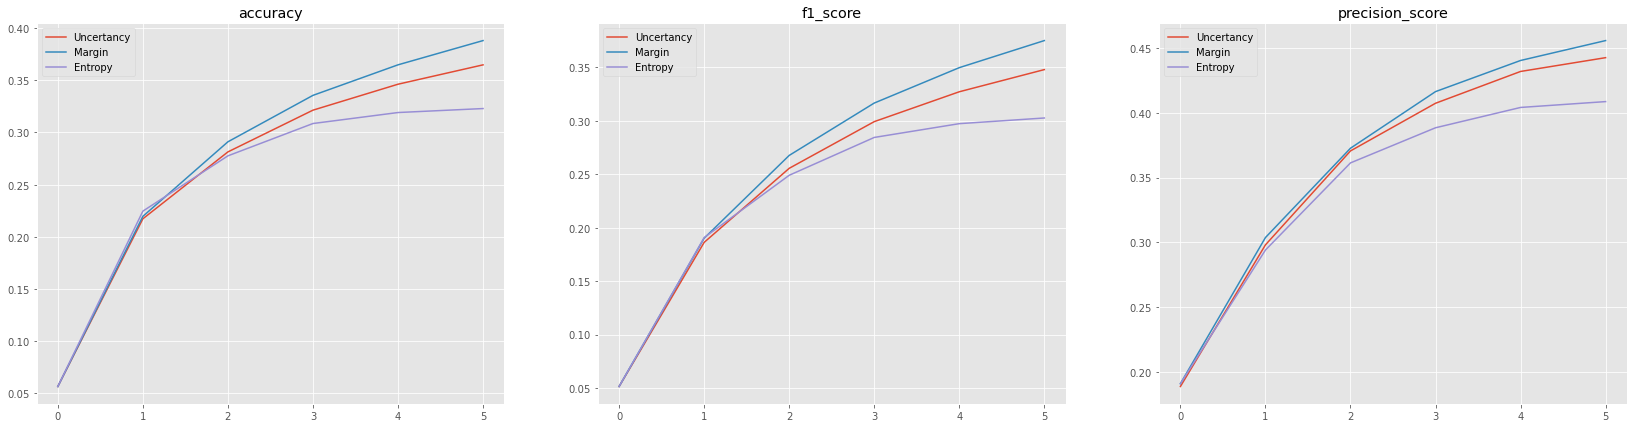

In [82]:
plot_metrics((labels, metrics))